In [71]:
import yfinance as yf
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
%matplotlib inline 



In [72]:
df = yf.Ticker('NQ=F')
df = df.history(start='2010-01-01', end='2024-01-01')

In [73]:
# Calcular medias móviles
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

In [74]:
df['Signal'] = 0
df.loc[df['SMA_50'] > df['SMA_200'], 'Signal'] = 1  # Compra 
df.loc[df['SMA_50'] < df['SMA_200'], 'Signal'] = -1  # Vende 

In [75]:
# Simular la ejecución de las órdenes
df['Position'] = df['Signal'].shift()  # Simular la ejecución al siguiente día
df['Strategy_Returns'] = df['Position'] * df['Close'].pct_change()  # 

In [76]:
# Eliminar NaNs
df.dropna(inplace=True)

# Graficar el rendimiento de la estrategia frente al activo
(df['Strategy_Returns'] + 1).cumprod().plot(label='Strategy', figsize=(10,5))
(df['Close'].pct_change() + 1).cumprod().plot(label='AAPL')
plt.legend();



In [ ]:
import backtrader as bt
df = yf.Ticker('AAPL')

In [78]:
# Descargar datos usando yfinance
data = bt.feeds.PandasData(dataname=df.history(start='2015-01-01', end='2024-01-01'))
																								

# Crear una clase de estrategia
class SMACross(bt.Strategy):
    def __init__(self):
        self.sma1 = bt.indicators.SimpleMovingAverage(self.data.close, period=50)
        self.sma2 = bt.indicators.SimpleMovingAverage(self.data.close, period=200)
        self.dataclose = self.data.close  # Referencia al precio de cierre
        
        self.values = [] 
    def next(self):
        self.values.append(self.broker.getvalue())
        if not self.position:  # No tenemos posición abierta
            if self.sma1 > self.sma2:  # Regla de entrada
                self.buy()
        elif self.sma1 < self.sma2:  # Regla de salida
            self.sell()

# Crear el cerebro y añadir estrategia
cerebro = bt.Cerebro()
cerebro.addstrategy(SMACross)
cerebro.adddata(data)

# Configurar capital inicial
cerebro.broker.setcash(10000)

# Ejecutar el backtest
print(f'Valor inicial: {cerebro.broker.getvalue()}')
cerebro.run()
print(f'Valor final: {cerebro.broker.getvalue()}')


Valor inicial: 10000
Valor final: 10128.726051052565


In [79]:
cerebro.broker.setcash(10000)


In [80]:
print(f'Valor inicial: {cerebro.broker.getvalue()}')
cerebro.run()
print(f'Valor final: {cerebro.broker.getvalue()}')


Valor inicial: 10000
Valor final: 10128.726051052565


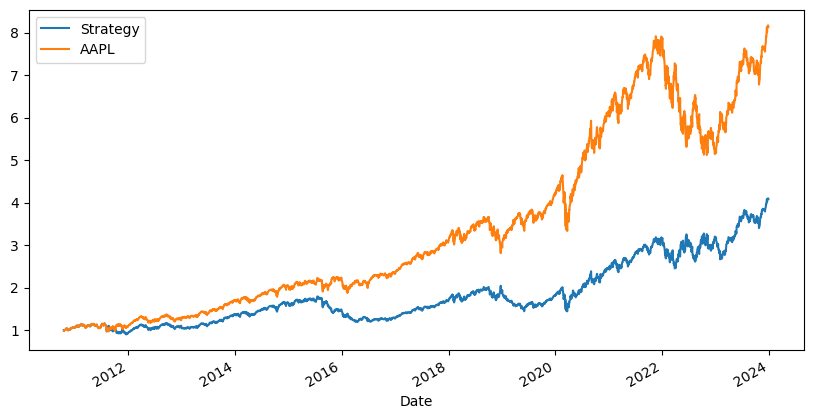

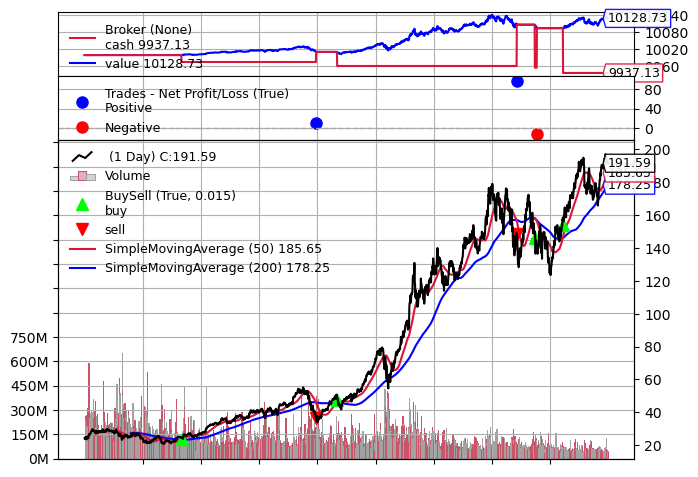

[[<Figure size 640x480 with 4 Axes>]]

In [81]:
cerebro.plot(iplot=False)

In [82]:
strategy = cerebro.run()[0] 
df = pd.DataFrame(strategy.values, columns=['Portfolio_Value'])
df['Strategy_Returns'] = df['Portfolio_Value'].pct_change()

In [83]:
total_return = (df['Strategy_Returns'] + 1).prod() - 1
annualized_return = (1 + total_return) ** (252 / len(df)) - 1  # Ajustado por 252 días de trading anuales
print(f'Rendimiento Total: {total_return:.2%}')
print(f'Rendimiento Anualizado: {annualized_return:.2%}')

Rendimiento Total: 1.29%
Rendimiento Anualizado: 0.16%


In [84]:
# Ratio de Sharpe
risk_free_rate = 0.01  # Supongamos que la tasa libre de riesgo es del 1%
excess_return = df['Strategy_Returns'].mean() - (risk_free_rate / 252)  # Retornos en exceso sobre la tasa libre de riesgo
sharpe_ratio = excess_return / df['Strategy_Returns'].std()
print(f'Ratio de Sharpe: {sharpe_ratio:.2f}')

Ratio de Sharpe: -0.21


In [85]:
# Máximo Drawdown
df['Cumulative_Returns'] = (df['Strategy_Returns'] + 1).cumprod()
df['Peak'] = df['Cumulative_Returns'].cummax()
df['Drawdown'] = (df['Cumulative_Returns'] - df['Peak']) / df['Peak']
max_drawdown = df['Drawdown'].min()
print(f'Máximo Drawdown: {max_drawdown:.2%}')

Máximo Drawdown: -0.48%


In [86]:
# Ratio de Ganancias/Pérdidas
winning_trades = df[df['Strategy_Returns'] > 0]['Strategy_Returns'].count()
losing_trades = df[df['Strategy_Returns'] <= 0]['Strategy_Returns'].count()
win_loss_ratio = winning_trades / losing_trades if losing_trades != 0 else np.inf
ganancia_media = df[df['Strategy_Returns'] > 0]['Strategy_Returns'].mean()
perdida_media = df[df['Strategy_Returns'] <= 0]['Strategy_Returns'].mean()
print(f'Operaciones Ganadoras: {winning_trades} -- Ganancia Media: {ganancia_media:.2%}')
print(f'Operaciones Perdedoras: {losing_trades} -- Pérdida Media: {perdida_media:.2%}')
print(f'Ratio Ganancias/Pérdidas: {win_loss_ratio:.2f}')


Operaciones Ganadoras: 832 -- Ganancia Media: 0.01%
Operaciones Perdedoras: 1232 -- Pérdida Media: -0.01%
Ratio Ganancias/Pérdidas: 0.68


In [87]:
df['Drawdown'].notna().any()

True

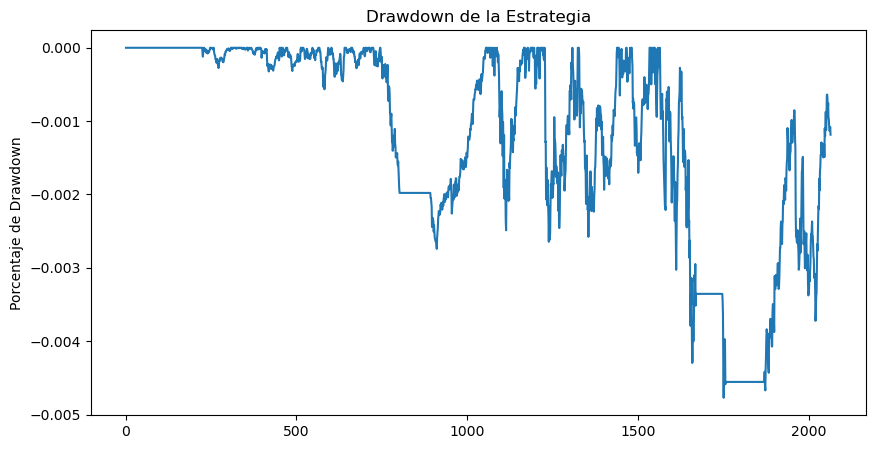

In [88]:
plt.figure(figsize=(10, 5))
df['Drawdown'].plot(label='Drawdown')
plt.title('Drawdown de la Estrategia')
plt.ylabel('Porcentaje de Drawdown')
plt.show()


In [89]:
df = yf.Ticker('AAPL')
df = df.history(start='2015-01-01', end='2024-01-01')


In [90]:
# Calcular medias móviles
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

In [91]:
# Definir reglas de entrada y salida
df['Signal'] = 0
df.loc[df['SMA_50'] > df['SMA_200'], 'Signal'] = 1  # Compra
df.loc[df['SMA_50'] < df['SMA_200'], 'Signal'] = -1  # Vende


In [92]:
# Simular la ejecución de las órdenes
df['Position'] = df['Signal'].shift()  # Shift para simular la ejecución al siguiente día

In [93]:
# Definir comisiones y slippage
commission = 0.001  # 0.1% por operación
slippage = 0.0005  # 0.05% de slippage en cada operación


In [94]:
# Calcular los retornos de la estrategia con comisiones y slippage
df['Returns'] = df['Close'].pct_change()  # Retornos diarios del activo
df['Strategy_Returns'] = df['Position'] * df['Returns']


In [95]:
# Aplicar comisiones y slippage
# Nota: Ajusta los valores de comisiones y slippage según el broker.
df['Strategy_Returns'] -= (abs(df['Position'].diff()) * (commission + slippage))  

In [96]:
# Eliminar NaNs
df.dropna(inplace=True)

In [97]:
# Calcular rendimiento total y anualizado
total_return = (df['Strategy_Returns'] + 1).prod() - 1
annualized_return = (1 + total_return) ** (252 / len(df)) - 1  # Ajustado por 252 días 

In [98]:
print(f'Rendimiento Total: {total_return:.2%}')
print(f'Rendimiento Anualizado: {annualized_return:.2%}')

Rendimiento Total: 148.42%
Rendimiento Anualizado: 11.74%


In [99]:
# Ratio de Sharpe
risk_free_rate = 0.01  # Supongamos que la tasa libre de riesgo es del 1%
excess_return = df['Strategy_Returns'].mean() - (risk_free_rate / 252)  # Retornos en exceso sobre la tasa libre de riesgo
sharpe_ratio = excess_return / df['Strategy_Returns'].std()
print(f'Ratio de Sharpe: {sharpe_ratio:.2f}')

Ratio de Sharpe: 0.03


In [100]:
# Drawdown Máximo
df['Cumulative_Returns'] = (df['Strategy_Returns'] + 1).cumprod()
df['Peak'] = df['Cumulative_Returns'].cummax()
df['Drawdown'] = (df['Cumulative_Returns'] - df['Peak']) / df['Peak']
max_drawdown = df['Drawdown'].min()
print(f'Máximo Drawdown: {max_drawdown:.2%}')


Máximo Drawdown: -62.49%


In [101]:
# Ratio de Ganancias/Pérdidas
winning_trades = df[df['Strategy_Returns'] > 0]['Strategy_Returns'].count()
losing_trades = df[df['Strategy_Returns'] <= 0]['Strategy_Returns'].count()
win_loss_ratio = winning_trades / losing_trades if losing_trades != 0 else np.inf
ganancia_media = df[df['Strategy_Returns'] > 0]['Strategy_Returns'].mean()
perdida_media = df[df['Strategy_Returns'] <= 0]['Strategy_Returns'].mean()
print(f'Operaciones Ganadoras: {winning_trades} -- Ganancia Media: {ganancia_media:.2%}')
print(f'Operaciones Perdedoras: {losing_trades} -- Pérdida Media: {perdida_media:.2%}')
print(f'Ratio Ganancias/Pérdidas: {win_loss_ratio:.2f}')

Operaciones Ganadoras: 1064 -- Ganancia Media: 1.30%
Operaciones Perdedoras: 1001 -- Pérdida Media: -1.26%
Ratio Ganancias/Pérdidas: 1.06


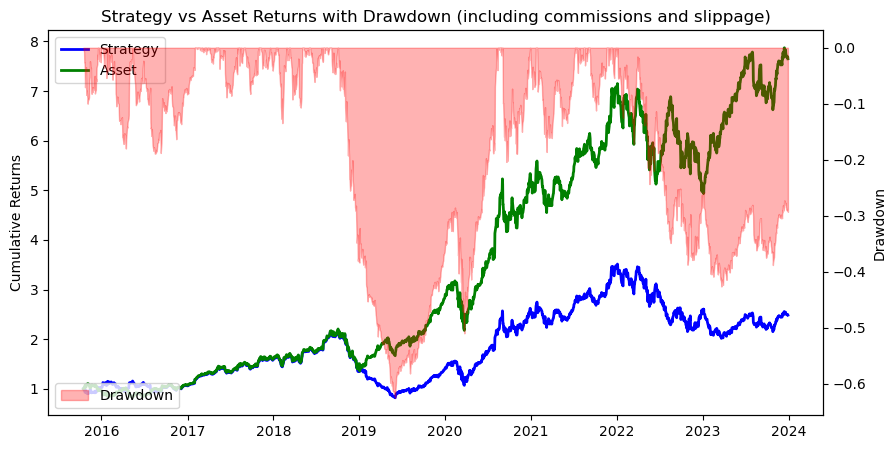

In [103]:
# Graficar el rendimiento de la estrategia frente al activo
fig, ax1 = plt.subplots(figsize=(10, 5))
# Graficar los rendimientos acumulados de la estrategia
ax1.plot(df.index, df['Cumulative_Returns'], label='Strategy', color='blue', lw=2)

# Graficar los rendimientos acumulados del activo directamente usando Close
ax1.plot(df.index, (df['Close'] / df['Close'].iloc[0]), label='Asset', color='green', lw=2)

ax1.set_ylabel('Cumulative Returns')
ax2 = ax1.twinx()
ax2.fill_between(df.index, df['Drawdown'], 0, color='red', alpha=0.3, label='Drawdown')
ax2.set_ylabel('Drawdown')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
plt.title('Strategy vs Asset Returns with Drawdown (including commissions and slippage)')
plt.show()

In [105]:
df = yf.Ticker('AAPL')
df = df.history(start='2015-01-01', end='2024-01-01')


In [106]:
# Definir función para calcular el rendimiento de la estrategia
def backtest_strategy(short_window, long_window):
    df['SMA_short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_long'] = df['Close'].rolling(window=long_window).mean()
    df['Signal'] = np.where(df['SMA_short'] > df['SMA_long'], 1, -1)
    df['Position'] = df['Signal'].shift()
    df['Strategy_Returns'] = df['Position'] * df['Close'].pct_change()
    return (df['Strategy_Returns'] + 1).cumprod()[-1] - 1  # Retorno total

In [107]:
# Definir el rango de parámetros a probar
short_windows = range(10, 100, 10)  # De 10 a 90 días
long_windows = range(50, 200, 10)  # De 50 a 190 días

In [109]:
import numpy as np

In [110]:
# Probar todas las combinaciones de parámetros
best_performance = -np.inf
best_params = (None, None)

for short_window in short_windows:
    for long_window in long_windows:
        if short_window >= long_window:
            continue  # Evitar combinaciones donde la media corta sea mayor o igual a la larga
        performance = backtest_strategy(short_window, long_window)
        if performance > best_performance:
            best_performance = performance
            best_params = (short_window, long_window)

print(f"Mejores parámetros: SMA corta={best_params[0]}, SMA larga={best_params[1]}")
print(f"Mejor rendimiento: {best_performance:.2%}")

/tmp/ipykernel_7707/2268757869.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (df['Strategy_Returns'] + 1).cumprod()[-1] - 1  # Retorno total


Mejores parámetros: SMA corta=80, SMA larga=180
Mejor rendimiento: 313.70%
